# Binary classificaton model using Big Query

In [1]:
PROJECT_ID = "fsi-env2"
! /opt/app-root/src/google-cloud-sdk/bin/gcloud config set project $PROJECT_ID

Updated property [core/project].


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery

In [3]:
# These are the features in the dataset.
# Dataset information: https://archive.ics.uci.edu/ml/datasets/census+income
# which exists now in: `bigquery-public-data.ml_datasets.census_adult_income`

_COLUMNS = [
    "age",
    "workclass",
    "functional_weight",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

# This is the label (target) we want to predict.
_LABEL_COLUMN = "income_bracket"

### Unused Features and Features that are Biased

In [4]:
UNUSED_COLUMNS = ["functional_weight", "education", "sex"]

# Data Preparation

In [5]:
# Create BQ client
client = bigquery.Client(location="US", project=PROJECT_ID)

In [6]:
# Dataset and table information
dataset_name = "census_tutorial"

# Create BigQuery dataset
dataset = client.create_dataset(dataset_name)

#### Extract Training and Evaluation dataframes

In [7]:
# This query will process 4.8 MB when run:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
"""
dataset = client.query(query).to_dataframe()
dataset.head()

,age,workclass,functional_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,297847,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,77,Private,344425,9th,5,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,10,United-States,<=50K
2,38,Private,131461,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,24,Haiti,<=50K
3,28,Private,190350,9th,5,Married-civ-spouse,Protective-serv,Wife,Black,Female,0,0,40,United-States,<=50K
4,37,Private,171090,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,48,United-States,<=50K


#### Training dataset

In [8]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) < 8
"""
train_dataset = client.query(query).to_dataframe()

#### Evaluation dataset

In [9]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 8
"""
eval_dataset = client.query(query).to_dataframe()

#### Testing dataset

In [10]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 9
"""
test_dataset = client.query(query).to_dataframe()

#### DataFrame length

In [11]:
len(dataset), len(train_dataset), len(eval_dataset), len(test_dataset)

(32561, 26192, 3268, 3101)

## Feature Engineering

In [13]:
# Checking Empty records (NULL) OR (?) and their percentage overall
query = """
SELECT
  COUNTIF(workclass IS NULL 
    OR LTRIM(workclass) LIKE '?') AS workclass,
  ROUND(COUNTIF(workclass IS NULL 
    OR LTRIM(workclass) LIKE '?') / COUNT(workclass) * 100) 
    AS workclass_percentage,
  COUNTIF(occupation IS NULL 
    OR LTRIM(occupation) LIKE '?') AS occupation,  
  ROUND(COUNTIF(occupation IS NULL 
    OR LTRIM(occupation) LIKE '?') / COUNT(occupation) * 100) 
    AS occupation_percentage,
  COUNTIF(native_country IS NULL 
    OR LTRIM(native_country) LIKE '?') AS native_country,
  ROUND(COUNTIF(native_country IS NULL 
    OR LTRIM(native_country) LIKE '?') / COUNT(native_country) * 100) 
    AS native_country_percentage
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
"""
client.query(query).to_dataframe()

,workclass,workclass_percentage,occupation,occupation_percentage,native_country,native_country_percentage
0,1836,6.0,1843,6.0,583,2.0


In [14]:
# Checking for workclass values.
query = """
SELECT
  workclass,
  COUNT(workclass) AS total_workclass
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY workclass
ORDER BY total_workclass DESC
"""
client.query(query).to_dataframe()

,workclass,total_workclass
0,Private,22696
1,Self-emp-not-inc,2541
2,Local-gov,2093
3,?,1836
4,State-gov,1298
5,Self-emp-inc,1116
6,Federal-gov,960
7,Without-pay,14
8,Never-worked,7


In [15]:
# Checking for occupation values.
query = """
SELECT
  occupation,
  COUNT(occupation) AS total_occupation
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY occupation
ORDER BY total_occupation DESC
"""
client.query(query).to_dataframe()

,occupation,total_occupation
0,Prof-specialty,4140
1,Craft-repair,4099
2,Exec-managerial,4066
3,Adm-clerical,3770
4,Sales,3650
5,Other-service,3295
6,Machine-op-inspct,2002
7,?,1843
8,Transport-moving,1597
9,Handlers-cleaners,1370


In [17]:
# Checking for native_country values.
query = """
SELECT
  native_country,
  COUNT(native_country) AS total_native_country
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY native_country
ORDER BY total_native_country DESC
"""
client.query(query).to_dataframe()

,native_country,total_native_country
0,United-States,29170
1,Mexico,643
2,?,583
3,Philippines,198
4,Germany,137
5,Canada,121
6,Puerto-Rico,114
7,El-Salvador,106
8,India,100
9,Cuba,95


In [18]:
# Checking for capital_gain
# Total records: 32561
query = """
SELECT
  capital_gain,
  income_bracket,
  COUNT(capital_gain) AS capital_gain_records
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY capital_gain, income_bracket  
ORDER BY capital_gain_records DESC
"""
client.query(query).to_dataframe()

,capital_gain,income_bracket,capital_gain_records
0,0,<=50K,23685
1,0,>50K,6164
2,15024,>50K,347
3,7688,>50K,284
4,7298,>50K,246
...,...,...,...
117,1639,<=50K,1
118,1455,<=50K,1
119,4931,<=50K,1
120,5060,<=50K,1


In [19]:
# Checking for capital_loss
# Total records: 32561
query = """
SELECT
  capital_loss,
  income_bracket,
  COUNT(capital_loss) AS capital_loss_records
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY capital_loss, income_bracket
ORDER BY capital_loss_records DESC
"""
client.query(query).to_dataframe()

,capital_loss,income_bracket,capital_loss_records
0,0,<=50K,23974
1,0,>50K,7068
2,1902,>50K,189
3,1977,>50K,168
4,1887,>50K,159
...,...,...,...
94,3683,>50K,1
95,2080,<=50K,1
96,1539,<=50K,1
97,1844,<=50K,1


In [20]:
# Checking for education
query = """
SELECT
  education,
  education_num      
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY education, education_num
ORDER BY education_num
"""
client.query(query).to_dataframe()

,education,education_num
0,Preschool,1
1,1st-4th,2
2,5th-6th,3
3,7th-8th,4
4,9th,5
5,10th,6
6,11th,7
7,12th,8
8,HS-grad,9
9,Some-college,10


/opt/app-root/lib64/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


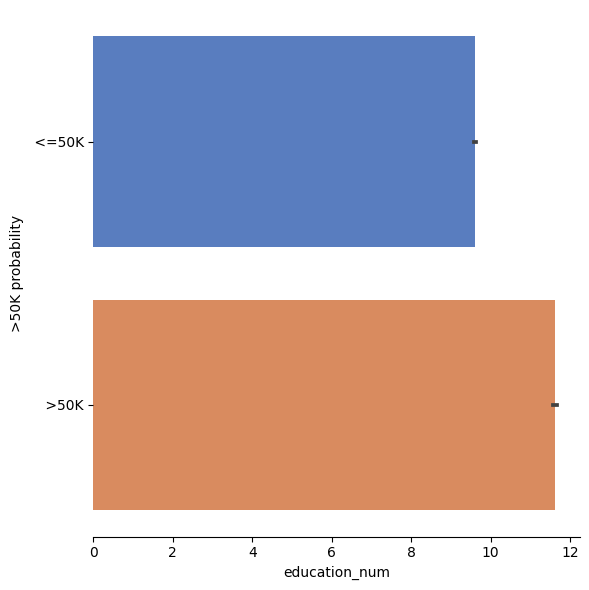

In [21]:
# Explore Education Num vs Income
g = sns.catplot(
    x="education_num",
    y="income_bracket",
    data=dataset,
    kind="bar",
    height=6,
    palette="muted",
)
g.despine(left=True)
g = g.set_ylabels(">50K probability")

In [22]:
# Checking for marital_status
query = """
SELECT
  marital_status            
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY marital_status
"""
client.query(query).to_dataframe()

,marital_status
0,Married-civ-spouse
1,Separated
2,Never-married
3,Divorced
4,Married-spouse-absent
5,Widowed
6,Married-AF-spouse


In [23]:
# Checking for relationship
query = """
SELECT
  relationship            
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY relationship
"""
client.query(query).to_dataframe()

,relationship
0,Wife
1,Husband
2,Own-child
3,Unmarried
4,Not-in-family
5,Other-relative


## Train the model

In [24]:
# Train a BQML model
train_query = """
CREATE OR REPLACE MODEL `census_tutorial.census_model`
  OPTIONS (
      model_type='logistic_reg',
      auto_class_weights=true,
      data_split_method='no_split',
      input_label_cols=['income_bracket'],
      max_iterations=15) AS
  SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country,        
      CASE 
        WHEN LTRIM(marital_status) IN 
          (
           'Never-married',
           'Divorced',
           'Separated',
           'Widowed'
          ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
           'Married-civ-spouse',
           'Married-spouse-absent',
           'Married-AF-spouse'
          ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,
      occupation,
      race,       
      hours_per_week,        
      income_bracket
    FROM   
      `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) < 8
      AND (occupation IS NOT NULL OR LTRIM(occupation) NOT LIKE '?%')
    GROUP BY  1, 2, 3, 4, 5, 6, 7, 8, 9
"""
client.query(train_query)

QueryJob<project=fsi-env2, location=US, id=15aa4fab-d7a7-408c-bba0-614671c594f3>

#### Model infomation

In [25]:
training_info = """
SELECT
  training_run,
  iteration,
  loss,
  eval_loss,
  duration_ms,
  learning_rate
FROM
  ML.TRAINING_INFO(MODEL `census_tutorial.census_model`)
ORDER BY iteration ASC
"""
client.query(training_info).to_dataframe()

,training_run,iteration,loss,eval_loss,duration_ms,learning_rate
0,0,0,0.668249,NaN,2541,0.2
1,0,1,0.626823,NaN,2881,0.4
2,0,2,0.567872,NaN,3507,0.8
3,0,3,0.507064,NaN,2952,1.6
4,0,4,0.481892,NaN,3344,3.2
5,0,5,0.439091,NaN,2542,6.4


## Model Evaluation

In [26]:
# Perform model evaluation
query_evaluate = """
SELECT 
  precision,
  recall,
  accuracy,
  f1_score,
  log_loss,
  roc_auc
FROM ML.EVALUATE (MODEL `census_tutorial.census_model`, 
  (
    SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country,        
      CASE 
        WHEN LTRIM(marital_status) IN 
          (
            'Never-married',
            'Divorced',
            'Separated',
            'Widowed'
            ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
            'Married-civ-spouse',
            'Married-spouse-absent',
            'Married-AF-spouse'
            ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,
      occupation,
      race,       
      hours_per_week,        
      income_bracket
    FROM   
      `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 8
      AND (occupation IS NOT NULL OR LTRIM(occupation) NOT LIKE '?%')
    GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9
    ))
"""
evaluation_job = client.query(query_evaluate).to_dataframe()

In [27]:
evaluation_job

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.565176,0.749054,0.78825,0.644252,0.429136,0.867521


## ROC
https://en.wikipedia.org/wiki/Precision_and_recall

In [29]:
# Perform model evaluation
query_roc_curve = """
SELECT
  threshold,
  recall,
  false_positive_rate,
  true_positives,
  false_positives,
  true_negatives,
  false_negatives
FROM
  ML.ROC_CURVE(MODEL `census_tutorial.census_model`,
  (
    SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country,        
      CASE 
        WHEN LTRIM(marital_status) IN 
          (
            'Never-married',
            'Divorced',
            'Separated',
            'Widowed'
            ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
            'Married-civ-spouse',
            'Married-spouse-absent',
            'Married-AF-spouse'
            ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,
      occupation,
      race,       
      hours_per_week,        
      income_bracket
    FROM   
       `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 8
      AND (occupation IS NOT NULL OR LTRIM(occupation) NOT LIKE '?%')
    GROUP BY  1, 2, 3, 4, 5, 6, 7, 8, 9))
"""
roc_curve_job = client.query(query_roc_curve).to_dataframe()
roc_curve_job

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.107254,0.991173,0.640347,786,1476,829,7
1,0.462657,0.790668,0.225597,627,520,1785,166
2,0.830225,0.276166,0.026030,219,60,2245,574
3,0.642070,0.575032,0.111497,456,257,2048,337
4,0.048860,0.996217,0.813449,790,1875,430,3
...,...,...,...,...,...,...,...
96,0.629795,0.600252,0.116269,476,268,2037,317
97,0.357656,0.876419,0.303688,695,700,1605,98
98,0.086997,0.993695,0.693275,788,1598,707,5
99,0.665703,0.546028,0.094577,433,218,2087,360


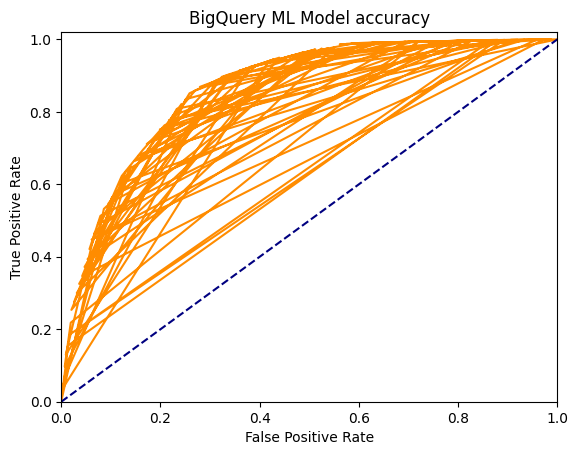

In [30]:
# Visualize History for Accuracy.
plt.title("BigQuery ML Model accuracy")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fpr = roc_curve_job["false_positive_rate"]
tpr = roc_curve_job["recall"]
plt.plot(fpr, tpr, color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.show()

## Model Predictions

In [31]:
query_prediction = """
SELECT
  income_bracket,
  predicted_income_bracket,
  predicted_income_bracket_probs
FROM
  ML.PREDICT(MODEL `census_tutorial.census_model`,
  (
    SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country,        
      CASE 
        WHEN LTRIM(marital_status) IN 
        (
            'Never-married',
            'Divorced',
            'Separated',
            'Widowed'
            ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
            'Married-civ-spouse',
            'Married-spouse-absent',
            'Married-AF-spouse'
            ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,
      occupation,
      race,       
      hours_per_week,        
      income_bracket
    FROM   
       `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 9
      AND occupation IS NOT NULL AND LTRIM(occupation) NOT LIKE '?%'
      GROUP BY  1, 2, 3, 4, 5, 6, 7, 8, 9
    ))
"""
predictions = client.query(query_prediction).to_dataframe()

In [32]:
predictions[["income_bracket", "predicted_income_bracket"]].head()

,income_bracket,predicted_income_bracket
0,<=50K,<=50K
1,<=50K,<=50K
2,<=50K,<=50K
3,<=50K,<=50K
4,<=50K,<=50K


In [33]:
predictions["predicted_income_bracket_probs"].head()

0    [{'label': ' >50K', 'prob': 0.4607157684458598...
1    [{'label': ' >50K', 'prob': 0.2575677010679178...
2    [{'label': ' >50K', 'prob': 0.1733996149863431...
3    [{'label': ' >50K', 'prob': 0.2470417790062081...
4    [{'label': ' >50K', 'prob': 0.2070207236556119...
Name: predicted_income_bracket_probs, dtype: object

In [34]:
predictions["predicted_income_bracket_probs"].tail()

2811    [{'label': ' >50K', 'prob': 0.2049420806983748...
2812    [{'label': ' >50K', 'prob': 0.0588662515448375...
2813    [{'label': ' >50K', 'prob': 0.0603900969891278...
2814    [{'label': ' >50K', 'prob': 0.6130855657545013...
2815    [{'label': ' >50K', 'prob': 0.0432984776357284...
Name: predicted_income_bracket_probs, dtype: object

#### Count the number of correct predictions:

In [35]:
_count = (
    predictions["income_bracket"].str.strip().str.lower()
    == predictions["predicted_income_bracket"].str.strip().str.lower()
)
# Group predictions:
_count.value_counts(normalize=True)
# Note: Set normalize=False to see grouped results.

True     0.791193
False    0.208807
Name: proportion, dtype: float64